# Pre procesado de datos para entrenamiento con xgb

Para el entrenamiento de ETA utilizando como modelo de regresión un xgb es necesario entregar los datos ya filtrados, es decir los viajes que cumplen con la condicion de ser dinámicos. Esto es lo que realizaremos  en este cuaderno.

Cargamos el dataset, seteamos los parametros para la función, es decir buscamos cual es el tiempo normal de viaje y el nombre de salida del archivo

Las tiempos normales para los OD son:

1. SDC-SA : 13000 para 226 km 13000
2. TO-CS : 5400 para 77 km 5400
3. CS-NV : 180*60 [s] para 189 km  
4. CS-SA : 320*60 [s] para 284 km  
5. TO-SA : 23700 [s] para 365 km  
6. PA-CS : 12600 [s] para 260 km  y para 190 km  (existen 2 rutas posibles, quizás haya que implementar dos modelos para este caso)

---
# Test

In [1]:
import pandas as pd 
from lib_pre_processing import processing_dynamics

In [2]:
destino = 'PA-CS'
path = '/root/eta-retorno/csv_od_traces/csv_od_traces_process/'
path_to_save = '/root/eta-retorno/csv_od_traces/csv_od_paradas/'
date = '20200101-20200630'
file_name = path+destino+'-'+date+'-traces_processed.csv'
file_output = path_to_save+'dynamics-'+destino+'.csv'
df = pd.read_csv(file_name)
od_dist = {'SDC-SA' : 13000, 'TO-CS' : 5400, 'CS-NV' : 10800, 
            'CS-SA' : 19200, 'TO-SA' : 23700, 'PA-CS' : 12600}

df_aux = df.groupby(by='Id').last()
df_aux.describe()

time_s    distance_m         hour          lat          lon  \
count    2389.000000  2.389000e+03  2389.000000  2389.000000  2389.000000   
mean    18808.199247  2.471089e+05    15.331101   -22.394499   -69.610034   
std     21157.298504  2.849658e+04     4.811049     0.000816     0.004868   
min      9821.000000  2.110500e+05     0.000000   -22.398000   -69.632000   
25%     11317.000000  2.420620e+05    13.000000   -22.394600   -69.609300   
50%     11930.000000  2.424480e+05    15.000000   -22.394200   -69.609100   
75%     14379.000000  2.504970e+05    19.000000   -22.394100   -69.608700   
max    408266.000000  1.337831e+06    23.000000   -22.389400   -69.607500   

           delta_t        delta_m     ETA  
count  2389.000000    2389.000000  2389.0  
mean     61.078275     767.480552     0.0  
std      31.768889    5875.779222     0.0  
min      10.000000       6.127866     0.0  
25%      60.000000     346.123884     0.0  
50%      60.000000     494.542616     0.0  
75%      60.000000     611.667252     0.0  
max    1013.000000  126809.749657     0.0

In [12]:
df_aux = df_aux[df_aux['time_s']<5.5*3600]
df_aux.groupby(by='Id').last().describe()

time_s     distance_m        hour         lat         lon  \
count    153.000000     153.000000  153.000000  153.000000  153.000000   
mean   18672.470588  360999.183007   15.928105  -23.577659  -68.430550   
std     2757.807937   52536.488134    3.785541    0.003098    0.006664   
min       31.000000      10.000000    7.000000  -23.606300  -68.483100   
25%    18840.000000  370743.000000   13.000000  -23.578500  -68.432400   
50%    19252.000000  371100.000000   16.000000  -23.577700  -68.430400   
75%    19539.000000  371432.000000   20.000000  -23.577000  -68.429200   
max    19794.000000  373102.000000   23.000000  -23.563600  -68.386900   

          delta_t       delta_m    ETA  
count  153.000000    153.000000  153.0  
mean    59.248366   1019.726147    0.0  
std      4.594449   1053.640204    0.0  
min     14.000000     10.194313    0.0  
25%     59.000000    919.799050    0.0  
50%     60.000000    973.960319    0.0  
75%     60.000000    997.048875    0.0  
max     61.000000  13799.762910    0.0

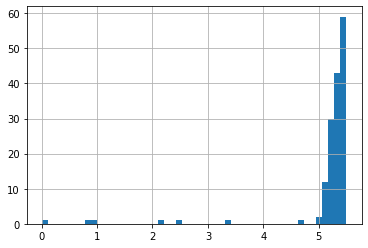

In [13]:
time = df_aux.time_s/3600
time.hist(bins=50)

---
# Procesamiento de todos los destinos

In [18]:
import os
import pandas as pd
import numpy as np
import datetime
from lib_pre_processing import *
from IPython.display import clear_output

folder = '/root/eta-retorno/csv_od_traces/csv_od_traces_process/'
folder_to_save = '/root/eta-retorno/csv_od_traces/csv_od_dynamics/'


#distancias normales por OD
od_dist = {'SDC-SA' : 13000, 'TO-CS' : 5400, 'CS-NV' : 10800, 
            'CS-SA' : 19200, 'TO-SA' : 6*3600, 'PA-CS' : 12600}
particular = ['TO-SA-20210101-20210630-traces_processed.csv',
             'TO-SA-20200101-20200630-traces_processed.csv',
             'TO-SA-20200701-20201231-traces_processed.csv']
for csv in os.listdir(folder):
#for csv in particular:
    if csv in particular:
        #setear carpetas
        filename=folder+csv
        file_output = folder_to_save+'dynamics-'+csv.split(".csv")[0]+'-v2.csv'
        destino = csv.split(".csv")[0].split("-")[0]+'-'+csv.split(".csv")[0].split("-")[1]
        print('Procesando Dataset ', csv)
        #leer dataset
        df = pd.read_csv(filename)
        #procesamos
        dynamics = processing_dynamics(df,tiempo_limite=od_dist[destino],file=file_output)
        print("Viajes totales: ", len(df.Id.unique().tolist()))
        print("Viajes normales : ",len(dynamics.Id.unique().tolist()) )
        print("El porcentaje es de ", round(len(dynamics.Id.unique().tolist())/len(df.Id.unique().tolist())*100,0), "%" )
        clear_output(wait=True)

Procesando Dataset  TO-SA-20210101-20210630-traces_processed.csv
step 1: round features
step 2: select filter dispatch id
# de viajes normales:  569
step 3: create the new DataFrame
step 4: Saving file
Viajes totales:  4542
Viajes normales :  569
El porcentaje es de  13.0 %


# Concat Datasets
En este caso no se debe concatenar el dataset en 1 solo gran set de datos, debido a que el modelo que se implementará es propio para cada modelo, es decir cada OD tendrá su propio modelo. Sin embargo, es necesario concatener las datasets del mismo origen y destino, ya que tenemos 3 distintos considerando las fechas.

In [24]:
import os
import pandas as pd

folder = '/root/eta-retorno/csv_od_traces/csv_od_dynamics/'
folder_to_save = '/root/eta-retorno/csv_to_train/'
df_acum = []
count = 0
OD = ['CS-NV','CS-SA','PA-CS','SDC-SA','TO-CS','TO-SA']
OD2 = ['TO-CS','TO-SA']
for od in OD2:
    print("Construyendo Dataset de "+od )
    for csv in os.listdir(folder):
        if od in csv:
            #print('file:', csv)
            df = pd.read_csv(folder+csv) 
            count += len(df.Id.unique())
            print('file: ', csv,' posee ',len(df.Id.unique()),' viajes')
            df_acum.append(df)
    name = 'dynamics-'+od+'-20200101-20210630.csv'
    df_total = pd.concat(df_acum)
    print('file total : '+ name+' posee', count,' viajes en total')
    print('---')
    df_total.to_csv(folder_to_save+name,index=False)
    df_total = None
    df_acum = []
    count = 0

dynamics-TO-SA-20210101-20210630-traces_processed-v2.csv
file: dynamics-TO-SA-20210101-20210630-traces_processed-v2.csv
file:  dynamics-TO-SA-20210101-20210630-traces_processed-v2.csv  posee  569  viajes
dynamics-TO-SA-20200101-20200630-traces_processed-v2.csv
file: dynamics-TO-SA-20200101-20200630-traces_processed-v2.csv
file:  dynamics-TO-SA-20200101-20200630-traces_processed-v2.csv  posee  638  viajes
dynamics-TO-SA-20200701-20201231-traces_processed-v2.csv
file: dynamics-TO-SA-20200701-20201231-traces_processed-v2.csv
file:  dynamics-TO-SA-20200701-20201231-traces_processed-v2.csv  posee  780  viajes
file total : dynamics-TO-SA-20200101-20210630-v2.csv posee 1987  viajes en total
---
